**Autoencoder Model and Clustering Technique for Customer Segmentation**

Customer segmentation is the problem of uncovering information about a firm's customer base, based on their interactions with the business. In most cases this interaction is in terms of their purchase behavior and patterns. Customer segmentation is the practice of separating customers into groups that reflect similarities among customers in each cluster. We explore some of the ways in which this can be used.

# Libraries & Data Loading

In [1]:
#Importing all required libraries
import pandas as pd
import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import colors
from matplotlib.colors import ListedColormap
cmap = colors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])
import seaborn as sns
plt.style.use('seaborn')
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import *
from tensorflow.keras import Model

In [2]:
#Reading the dataset
data = pd.read_csv('../input/customer-personality-analysis/marketing_campaign.csv',sep='\t',parse_dates=['Dt_Customer'])
data.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-04-09,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-08-03,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-10-02,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,5,0,0,0,0,0,0,3,11,0


In [3]:
#Information on features
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ID                   2240 non-null   int64         
 1   Year_Birth           2240 non-null   int64         
 2   Education            2240 non-null   object        
 3   Marital_Status       2240 non-null   object        
 4   Income               2216 non-null   float64       
 5   Kidhome              2240 non-null   int64         
 6   Teenhome             2240 non-null   int64         
 7   Dt_Customer          2240 non-null   datetime64[ns]
 8   Recency              2240 non-null   int64         
 9   MntWines             2240 non-null   int64         
 10  MntFruits            2240 non-null   int64         
 11  MntMeatProducts      2240 non-null   int64         
 12  MntFishProducts      2240 non-null   int64         
 13  MntSweetProducts     2240 non-nul

* There are missing values in income
* There are some categorical features in our dataset

# Data Preprocessing
Data preprocessing is a data mining technique which is used to transform the raw data in a useful and efficient format.

**Steps Involved in Data Preprocessing:**
1. Data Cleaning
1. Data Transformation
1. Data Reduction

In [4]:
print(data.Education.value_counts())
#Segmenting Education levels in three groups
data.Education = data.Education.replace({'PhD':'PostGraduation','Master':'PostGraduation','2n Cycle':'UnderGraduation','Basic':'UnderGraduation'})
print('-'*30)
print(data.Education.value_counts())

Graduation    1127
PhD            486
Master         370
2n Cycle       203
Basic           54
Name: Education, dtype: int64
------------------------------
Graduation         1127
PostGraduation      856
UnderGraduation     257
Name: Education, dtype: int64


In [5]:
print(data.Marital_Status.value_counts())
#Segmenting Marital Status in two groups
data.Marital_Status = data.Marital_Status.replace({'Married':'Together','Single':'Alone','Divorced':'Alone','Widow':'Alone','Absurd':'Alone','YOLO':'Alone'})
print('-'*40)
print(data.Marital_Status.value_counts())

Married     864
Together    580
Single      480
Divorced    232
Widow        77
Alone         3
Absurd        2
YOLO          2
Name: Marital_Status, dtype: int64
----------------------------------------
Together    1444
Alone        796
Name: Marital_Status, dtype: int64


In [6]:
#Drop NA values
data.dropna(inplace=True)
#Dropping the outlier by setting a cap on income
data = data[data.Income<600000]
#Dropping some of the features
data.drop(['ID','Year_Birth','Dt_Customer','Z_CostContact','Z_Revenue'],axis=1,inplace=True)
#New feature for total spendings on various items
data["Spent"] = data["MntWines"] + data["MntFruits"] + data["MntMeatProducts"] + data["MntFishProducts"] + data["MntSweetProducts"] + data["MntGoldProds"]
#New feature for total members in the householde
data['Family_Size'] = data.Kidhome + data.Teenhome + data.Marital_Status.replace({'Alone':1,'Together':2})
#Feature pertaining parenthood
data['Is_Parent'] = np.where((data.Kidhome + data.Teenhome)>0,1,0)
data.head()

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Spent,Family_Size,Is_Parent
0,Graduation,Alone,58138.0,0,0,58,635,88,546,172,...,0,0,0,0,0,0,1,1617,1,0
1,Graduation,Alone,46344.0,1,1,38,11,1,6,2,...,0,0,0,0,0,0,0,27,3,1
2,Graduation,Together,71613.0,0,0,26,426,49,127,111,...,0,0,0,0,0,0,0,776,2,0
3,Graduation,Together,26646.0,1,0,26,11,4,20,10,...,0,0,0,0,0,0,0,53,3,1
4,PostGraduation,Together,58293.0,1,0,94,173,43,118,46,...,0,0,0,0,0,0,0,422,3,1


In [7]:
#Converting the labels into a numeric form so as to convert them into the machine-readable form
label_encoder = LabelEncoder()
for item in ['Education','Marital_Status']:
    data[item] = data[[item]].apply(label_encoder.fit_transform)
data.head()

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Spent,Family_Size,Is_Parent
0,0,0,58138.0,0,0,58,635,88,546,172,...,0,0,0,0,0,0,1,1617,1,0
1,0,0,46344.0,1,1,38,11,1,6,2,...,0,0,0,0,0,0,0,27,3,1
2,0,1,71613.0,0,0,26,426,49,127,111,...,0,0,0,0,0,0,0,776,2,0
3,0,1,26646.0,1,0,26,11,4,20,10,...,0,0,0,0,0,0,0,53,3,1
4,1,1,58293.0,1,0,94,173,43,118,46,...,0,0,0,0,0,0,0,422,3,1


In [8]:
#Standardizes a feature by subtracting the mean and then scaling to unit variance
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)
scaled_data

array([[-0.89455036, -1.34835684,  0.28660409, ...,  1.67501109,
        -1.75815323, -1.58088903],
       [-0.89455036, -1.34835684, -0.26140705, ..., -0.96272705,
         0.45013109,  0.63255547],
       [-0.89455036,  0.74164344,  0.91272331, ...,  0.2798301 ,
        -0.65401107, -1.58088903],
       ...,
       [-0.89455036, -1.34835684,  0.2328438 , ...,  1.05124409,
        -1.75815323, -1.58088903],
       [ 0.56883889,  0.74164344,  0.80269361, ...,  0.39098007,
         0.45013109,  0.63255547],
       [ 0.56883889,  0.74164344,  0.0417787 , ..., -0.7221786 ,
         1.55427326,  0.63255547]])

# PCA

The higher the number of features, the harder it is to work with it. Many of these features are correlated, and hence redundant. This is why will be performing dimensionality reduction on the selected features before putting them through a classifier.

Dimensionality reduction is the process of reducing the number of random variables under consideration, by obtaining a set of principal variables.

In [9]:
#Transformation of data
pca = PCA(n_components=3)
pca_data = pd.DataFrame(pca.fit_transform(scaled_data),columns=['pca1', 'pca2', 'pca3'])
pca_data.head()

,pca1,pca2,pca3
0,4.658543,-0.864419,-0.186152
1,-2.683831,-0.473533,-0.092050
2,2.088131,-0.502727,-1.115640
3,-2.729011,-0.828009,-0.026779
4,-0.713792,0.668439,-0.780875


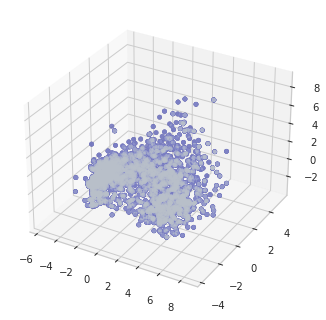

In [10]:
#Plotting the reduced data
ax = plt.axes(projection='3d')
for color in ['black', 'blue', '#B9C0C9']:
    n = 2340
    x, y = np.random.rand(2, n)
    scale = 200.0 * np.random.rand(n)
    ax.scatter3D(pca_data['pca1'],pca_data['pca2'],pca_data['pca3'],c=color,marker='o');

# Autoencoder

In [12]:
#Input Lyer
input_df = Input(shape =(data.shape[1],))
#Encoding
x = Dense(500, activation = 'relu')(input_df)
x = Dense(500, activation = 'relu')(x)
x = Dense(2000, activation = 'relu')(x)
#Decoding
encoded = Dense(2000, activation = 'relu')(x)
x = Dense(500, activation = 'relu')(encoded)
x = Dense(500, activation = 'relu')(x)
#Output Layer
decoded = Dense(data.shape[1])(x)

#autoencoder
autoencoder = Model(input_df, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

An autoencoder is a regression task where the network is asked to predict its input. These networks has a tight bottleneck of a few neurons in the middle, forcing them to create effective representations that compress the input into a low dimensional code that can be used by the decoder to reproduce the original input.

In [13]:
autoencoder.fit(data,data,batch_size=128,epochs=100,verbose=3)

2022-02-04 08:46:53.954636: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100
Epoch 62/100
Epoch 63/100
Epoch 64/100
Epoch 65/100
Epoch 66/100
Epoch 67/100
Epoch 68/100
Epoch 69/100
Epoch 70/100
Epoch 71/100
Epoch 72/100
Epoch 73/100
Epoch 74/100
Epoch 75/100
Epoch 76/100
Epoch 77/100
Epoch 78

In [14]:
encoded_data = autoencoder.predict(scaled_data)

# Clustering

Steps involved in the Clustering
1. Elbow Method to determine the number of clusters to be formed
1. Clustering
1. Examining the clusters formed via scatter plot

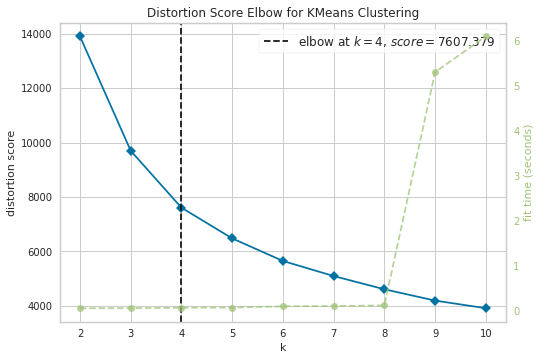

In [15]:
#Elbow method to find numbers of clusters to make
elbow = KElbowVisualizer(KMeans(), k=10)
elbow.fit(pca_data)
elbow.show();

In cluster analysis, the elbow method is a heuristic used in determining the number of clusters in a data set. The method consists of plotting the explained variation as a function of the number of clusters, and picking the elbow of the curve as the number of clusters to use.

The K-means clustering algorithm is used to find groups which have not been explicitly labeled in the data. This can be used to confirm business assumptions about what types of groups exist or to identify unknown groups in complex data sets.

In [16]:
kmeans = KMeans(4)
kmeans.fit(encoded_data)
labels = kmeans.labels_
y = kmeans.fit_predict(scaled_data)
pca_data['Cluster'] = y
#Adding the cluster to original dataset
data['Cluster'] = y

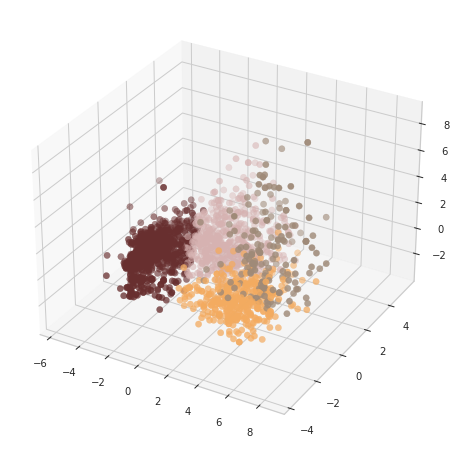

In [17]:
#3-D distribution of the clusters
plt.figure(figsize=(10,8))
ax = plt.axes(projection='3d')
ax.scatter3D(pca_data['pca1'],pca_data['pca2'],pca_data['pca3'],c=pca_data['Cluster'],cmap=cmap,marker='o',s=40);

We do not have a tagged feature to evaluate or score our model. We will be having a look at the data in light of clusters via exploratory data analysis and drawing conclusions.

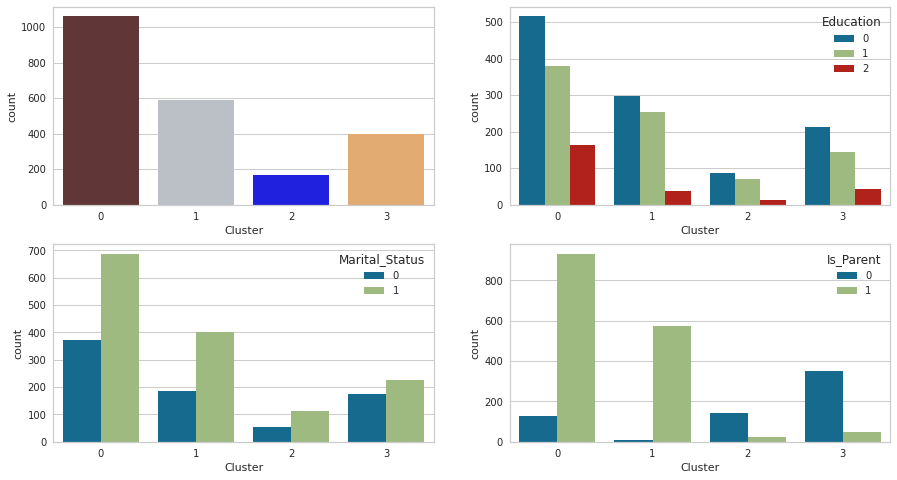

In [18]:
f,ax=plt.subplots(2,2,figsize=(15,8))
sns.countplot('Cluster',data=data,ax=ax[0,0],palette=["#682F2F","#B9C0C9", "blue","#F3AB60"]);
sns.countplot('Cluster',data=data,ax=ax[0,1], hue='Education');
sns.countplot('Cluster',data=data,ax=ax[1,0], hue='Marital_Status');
sns.countplot('Cluster',data=data,ax=ax[1,1], hue='Is_Parent');

# Profiling

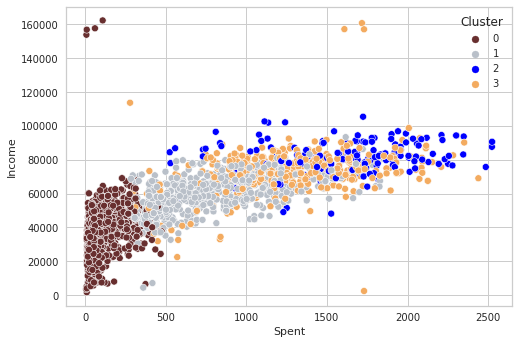

In [19]:
sns.scatterplot(data=data,x='Spent',y='Income',hue='Cluster',palette=["#682F2F","#B9C0C9", "blue","#F3AB60"]);

We have formed the clusters and looked at their purchasing habits. Let's see who all are there in these clusters. For that, we will be profiling the clusters formed and come to a conclusion about who is our star customer and who needs more attention from the store.

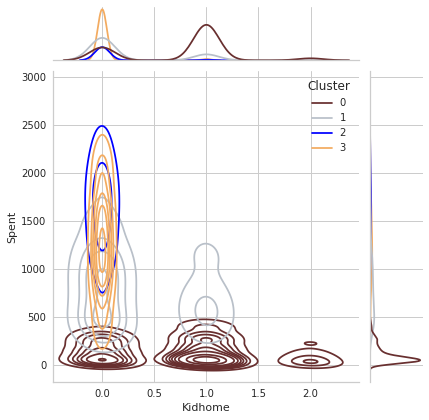

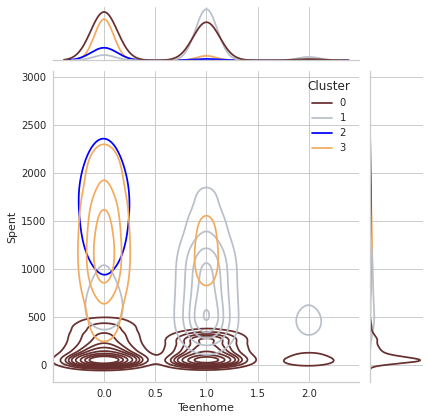

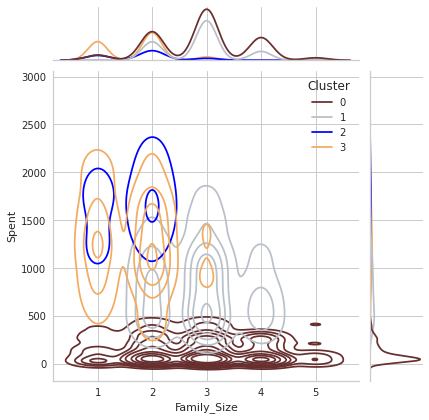

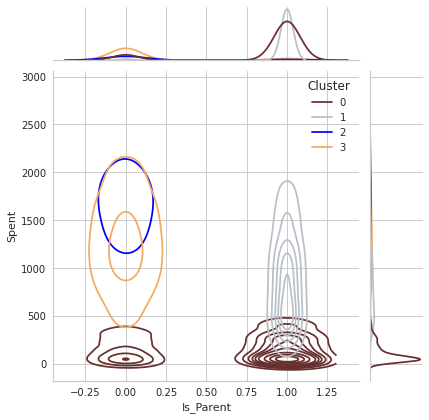

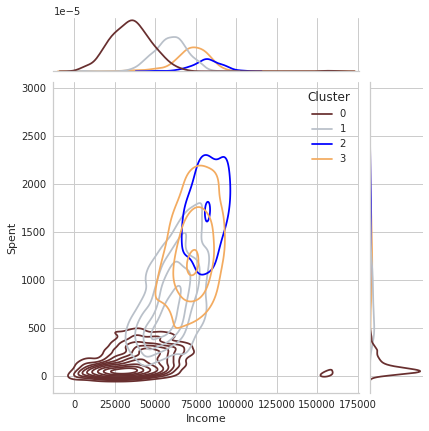

In [20]:
features = ["Kidhome","Teenhome", "Family_Size", "Is_Parent", "Income"]

for item in features:
    sns.jointplot(x=data[item], y=data["Spent"], hue =data["Cluster"], kind="kde", palette=["#682F2F","#B9C0C9", "blue","#F3AB60"]);

* **Cluster 0** 
1. Low Spent and Low Income 
1. Majority of these are parent 
1. At the max 5 memebrs in the family

* **Cluster 1** 
1. Average Spent & Average Income 
1. Definitely a parent 
1. At the max 4 memebrs in the family

* **Cluster 2**
1. High Spent and High Income 
1. Definitely not a parent 
1. At the max 2 memebrs in the family

* **Cluster 3** 
1. High Spent and Average Income 
1. Definitely not a parent 
1. At the max 3 memebrs in the family